In [1]:
import inspect
import json
import os
import numpy as np
from concurrent.futures import Future
from executorlib import SingleNodeExecutor, get_item_from_future
from executorlib.standalone.select import FutureSelector
from executorlib.task_scheduler.interactive.dependency_plot import (
    plot_dependency_graph_function,
)

In [2]:
function_str = '''
import os
from conda_subprocess import check_output
import shutil


def generate_mesh(domain_size: float, source_directory: str) -> str:
    stage_name = "preprocessing"
    gmsh_output_file_name = "square.msh"
    source_file_name ="unit_square.geo"
    os.makedirs(stage_name, exist_ok=True)
    _copy_file_from_source(stage_name=stage_name, source_file_name=source_file_name, source_directory=source_directory)
    _ = check_output(
        [
            "gmsh", "-2", "-setnumber", "domain_size", str(domain_size),
            source_file_name, "-o", gmsh_output_file_name
        ],
        prefix_name=stage_name,
        cwd=stage_name,
        universal_newlines=True,
    ).split("\\n")
    return os.path.abspath(os.path.join(stage_name, gmsh_output_file_name))


def convert_to_xdmf(gmsh_output_file : str) -> dict:
    stage_name = "preprocessing"
    meshio_output_file_name = "square.xdmf"
    os.makedirs(stage_name, exist_ok=True)
    _copy_file(stage_name=stage_name, source_file=gmsh_output_file)
    _ = check_output(
        ["meshio", "convert", os.path.basename(gmsh_output_file), meshio_output_file_name],
        prefix_name=stage_name,
        cwd=stage_name,
        universal_newlines=True,
    ).split("\\n")
    return {
        "xdmf_file": os.path.abspath(os.path.join(stage_name, meshio_output_file_name)),
        "h5_file": os.path.join(os.path.abspath(stage_name), "square.h5"),
    }


def poisson(meshio_output_xdmf: str, meshio_output_h5: str, source_directory: str) -> dict:
    stage_name = "processing"
    poisson_output_pvd_file_name = "poisson.pvd"
    poisson_output_numdofs_file_name = "numdofs.txt"
    source_file_name = "poisson.py"
    os.makedirs(stage_name, exist_ok=True)
    _copy_file_from_source(stage_name=stage_name, source_file_name=source_file_name, source_directory=source_directory)
    _copy_file(stage_name=stage_name, source_file=meshio_output_xdmf)
    _copy_file(stage_name=stage_name, source_file=meshio_output_h5)
    _ = check_output(
        [
            "python", "poisson.py", "--mesh", os.path.basename(meshio_output_xdmf), "--degree", "2",
            "--outputfile", poisson_output_pvd_file_name, "--num-dofs", poisson_output_numdofs_file_name
        ],
        prefix_name=stage_name,
        cwd=stage_name,
        universal_newlines=True,
    ).split("\\n")
    return {
        "numdofs": _poisson_collect_output(numdofs_file=os.path.join(stage_name, poisson_output_numdofs_file_name)),
        "pvd_file": os.path.abspath(os.path.join(stage_name, poisson_output_pvd_file_name)),
        "vtu_file": os.path.abspath(os.path.join(stage_name, "poisson000000.vtu")),
    }


def plot_over_line(poisson_output_pvd_file: str, poisson_output_vtu_file: str, source_directory: str) -> str:
    stage_name = "postprocessing"
    pvbatch_output_file_name = "plotoverline.csv"
    source_file_name = "postprocessing.py"
    os.makedirs(stage_name, exist_ok=True)
    _copy_file_from_source(stage_name=stage_name, source_file_name=source_file_name, source_directory=source_directory)
    _copy_file(stage_name=stage_name, source_file=poisson_output_pvd_file)
    _copy_file(stage_name=stage_name, source_file=poisson_output_vtu_file)
    _ = check_output(
        ["pvbatch", source_file_name, os.path.basename(poisson_output_pvd_file), pvbatch_output_file_name],
        prefix_name=stage_name,
        cwd=stage_name,
        universal_newlines=True,
    ).split("\\n")
    return os.path.abspath(os.path.join("postprocessing", pvbatch_output_file_name))


def substitute_macros(pvbatch_output_file: str, ndofs: int, domain_size: float, source_directory: str) -> str:
    stage_name = "postprocessing"
    source_file_name = "prepare_paper_macros.py"
    template_file_name = "macros.tex.template"
    macros_output_file_name = "macros.tex"
    os.makedirs(stage_name, exist_ok=True)
    _copy_file_from_source(stage_name=stage_name, source_file_name=source_file_name, source_directory=source_directory)
    _copy_file_from_source(stage_name=stage_name, source_file_name=template_file_name, source_directory=source_directory)
    _copy_file(stage_name=stage_name, source_file=pvbatch_output_file)
    _ = check_output(
        [
            "python", "prepare_paper_macros.py", "--macro-template-file", template_file_name,
            "--plot-data-path", os.path.basename(pvbatch_output_file), "--domain-size", str(domain_size),
            "--num-dofs", str(ndofs), "--output-macro-file", macros_output_file_name,
        ],
        prefix_name=stage_name,
        cwd=stage_name,
        universal_newlines=True,
    ).split("\\n")
    return os.path.abspath(os.path.join(stage_name, macros_output_file_name))


def compile_paper(macros_tex: str, plot_file: str, source_directory: str) -> str:
    stage_name = "postprocessing"
    paper_output = "paper.pdf"
    source_file_name = "paper.tex"
    os.makedirs(stage_name, exist_ok=True)
    _copy_file_from_source(stage_name=stage_name, source_file_name=source_file_name, source_directory=source_directory)
    _copy_file(stage_name=stage_name, source_file=macros_tex)
    _copy_file(stage_name=stage_name, source_file=plot_file)
    _ = check_output(
        ["tectonic", source_file_name],
        prefix_name=stage_name,
        universal_newlines=True,
        cwd=stage_name,
    ).split("\\n")
    return os.path.abspath(os.path.join(stage_name, paper_output))


def _poisson_collect_output(numdofs_file: str) -> int:
    with open(os.path.join(numdofs_file), "r") as f:
        return int(f.read())


def _copy_file(stage_name: str, source_file: str):
    input_file = os.path.join(os.path.abspath(stage_name), os.path.basename(source_file))
    if input_file != source_file:
        shutil.copyfile(source_file, input_file)


def _copy_file_from_source(stage_name: str, source_file_name: str, source_directory: str):
    source_file = os.path.join(source_directory, source_file_name)
    shutil.copyfile(source_file, os.path.join(stage_name, source_file_name))
'''

with open("workflow.py", "w") as f:
    f.write(function_str)

In [3]:
from workflow import (
    generate_mesh, 
    convert_to_xdmf,
    poisson,
    plot_over_line,
    substitute_macros,
    compile_paper,
)

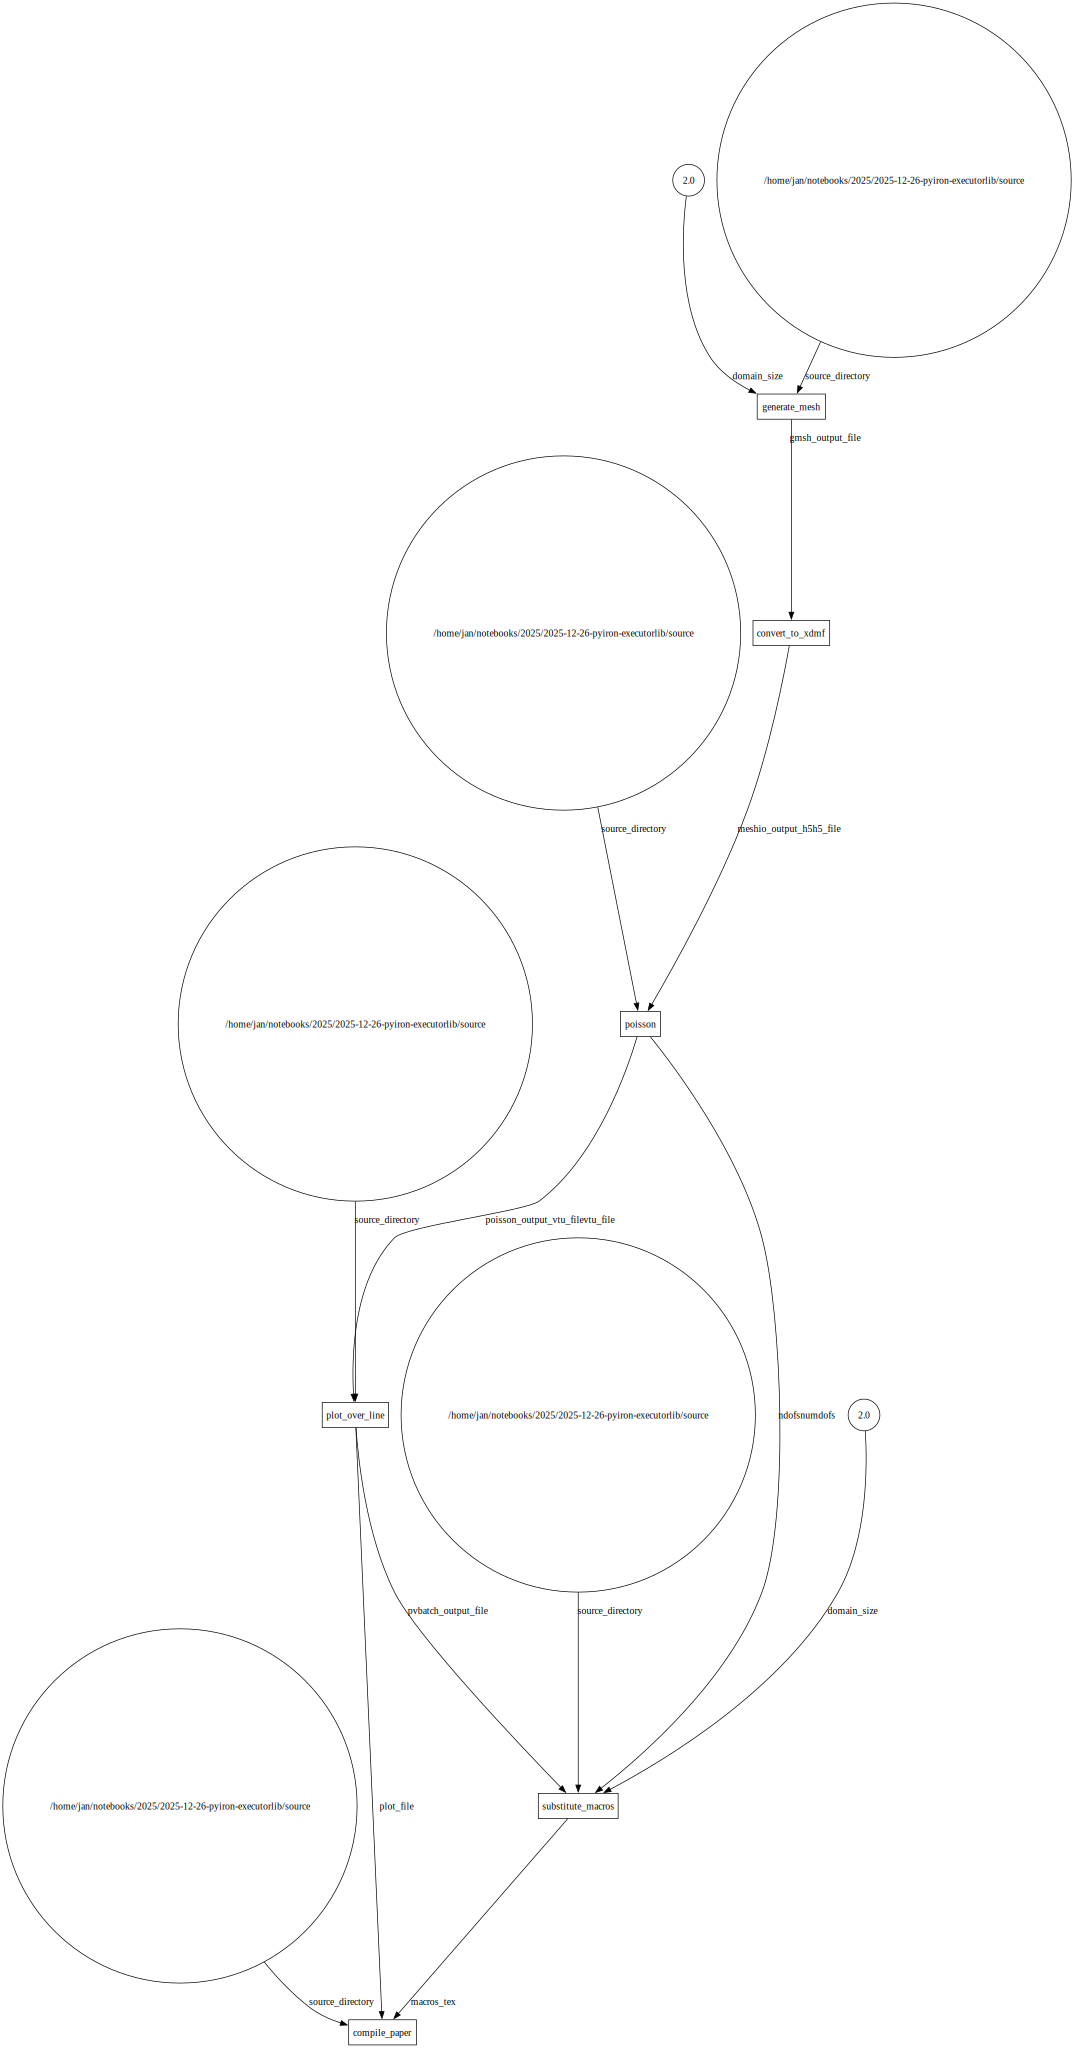

In [4]:
domain_size = 2.0
source_directory = os.path.abspath(os.path.join(os.curdir, "source"))

with SingleNodeExecutor(plot_dependency_graph=True) as exe:
    gmsh_output_file = exe.submit(
        generate_mesh,
        domain_size=domain_size,
        source_directory=source_directory,
    )
    meshio_output_dict = exe.submit(
        convert_to_xdmf,
        gmsh_output_file=gmsh_output_file,
    )
    poisson_dict = exe.submit(
        poisson,
        meshio_output_xdmf=get_item_from_future(meshio_output_dict, key="xdmf_file"), 
        meshio_output_h5=get_item_from_future(meshio_output_dict, key="h5_file"),
        source_directory=source_directory,
    )
    pvbatch_output_file = exe.submit(
        plot_over_line,
        poisson_output_pvd_file=get_item_from_future(poisson_dict, key="pvd_file"), 
        poisson_output_vtu_file=get_item_from_future(poisson_dict, key="vtu_file"),
        source_directory=source_directory,
    )
    macros_tex_file = exe.submit(
        substitute_macros,
        pvbatch_output_file=pvbatch_output_file, 
        ndofs=get_item_from_future(poisson_dict, key="numdofs"), 
        domain_size=domain_size,
        source_directory=source_directory,
    )
    paper_output = exe.submit(
        compile_paper,
        macros_tex=macros_tex_file, 
        plot_file=pvbatch_output_file,
        source_directory=source_directory,
    )
    task_hash_dict = exe._task_scheduler._task_hash_dict.copy()
    future_hash_dict = exe._task_scheduler._future_hash_dict.copy()

In [5]:
def extend_args(funct_dict):
    sig = inspect.signature(funct_dict["fn"])
    args = sig.bind(*funct_dict["args"], **funct_dict["kwargs"])
    funct_dict["signature"] = args.arguments
    return funct_dict


task_hash_modified_dict = {
    k: extend_args(funct_dict=v)
    for k, v in task_hash_dict.items()
}
task_hash_modified_dict

{b'\x80\x05\x95\xa7\x00\x00\x00\x00\x00\x00\x00}\x94(\x8c\x02fn\x94\x8c\x08workflow\x94\x8c\rgenerate_mesh\x94\x93\x94\x8c\x04args\x94]\x94\x8c\x06kwargs\x94}\x94(\x8c\x0bdomain_size\x94G@\x00\x00\x00\x00\x00\x00\x00\x8c\x10source_directory\x94\x8c=/home/jan/notebooks/2025/2025-12-26-pyiron-executorlib/source\x94uu.': {'fn': <function workflow.generate_mesh(domain_size: float, source_directory: str) -> str>,
  'args': (),
  'kwargs': {'domain_size': 2.0,
   'source_directory': '/home/jan/notebooks/2025/2025-12-26-pyiron-executorlib/source'},
  'future': <Future at 0x7f8940304e60 state=finished returned NoneType>,
  'resource_dict': {},
  'signature': {'domain_size': 2.0,
   'source_directory': '/home/jan/notebooks/2025/2025-12-26-pyiron-executorlib/source'}},
 b'\x80\x05\x95\x06\x01\x00\x00\x00\x00\x00\x00}\x94(\x8c\x02fn\x94\x8c\x08workflow\x94\x8c\x0fconvert_to_xdmf\x94\x93\x94\x8c\x04args\x94]\x94\x8c\x06kwargs\x94}\x94\x8c\x10gmsh_output_file\x94C\xb2\x80\x05\x95\xa7\x00\x00\x00\x0

In [6]:
def generate_nodes_and_edges_for_plotting(
    task_hash_dict: dict, future_hash_inverse_dict: dict
) -> tuple[list, list]:
    """
    Generate nodes and edges for visualization.

    Args:
        task_hash_dict (dict): Dictionary mapping task hash to task information.
        future_hash_inverse_dict (dict): Dictionary mapping future hash to future object.

    Returns:
        Tuple[list, list]: Tuple containing the list of nodes and the list of edges.
    """
    node_lst: list = []
    edge_lst: list = []
    hash_id_dict: dict = {}

    def add_element(arg, link_to, label=""):
        """
        Add element to the node and edge lists.

        Args:
            arg: Argument to be added.
            link_to: ID of the node to link the element to.
            label (str, optional): Label for the edge. Defaults to "".
        """
        if isinstance(arg, FutureSelector):
            edge_lst.append(
                {
                    "start": hash_id_dict[future_hash_inverse_dict[arg._future]],
                    "end": link_to,
                    "label": label + str(arg._selector),
                    "end_label": label,
                    "start_label": str(arg._selector),
                }
            )
        elif isinstance(arg, Future):
            edge_lst.append(
                {
                    "start": hash_id_dict[future_hash_inverse_dict[arg]],
                    "end": link_to,
                    "label": label,
                }
            )
        elif isinstance(arg, list) and any(isinstance(a, Future) for a in arg):
            lst_no_future = [a if not isinstance(a, Future) else "$" for a in arg]
            node_id = len(node_lst)
            node_lst.append(
                {
                    "name": str(lst_no_future), 
                    "value": "python_workflow_definition.shared.get_list", 
                    "id": node_id, 
                    "type": "function", 
                    "shape": "box",
                }
            )
            edge_lst.append(
                {
                    "start": node_id, 
                    "end": link_to, 
                    "label": label,
                }
            )
            for i, a in enumerate(arg):
                if isinstance(a, Future):
                    add_element(arg=a, link_to=node_id, label=str(i))
        elif isinstance(arg, dict) and any(isinstance(a, Future) for a in arg.values()):
            dict_no_future = {
                kt: vt if not isinstance(vt, Future) else "$" for kt, vt in arg.items()
            }
            node_id = len(node_lst)
            node_lst.append(
                {
                    "name": str(dict_no_future), 
                    "value": "python_workflow_definition.shared.get_dict", 
                    "id": node_id, 
                    "type": "function",
                    "shape": "box",
                }
            )
            edge_lst.append(
                {
                    "start": node_id, 
                    "end": link_to, 
                    "label": label,
                }
            )
            for kt, vt in arg.items():
                add_element(arg=vt, link_to=node_id, label=kt)
        else:
            value_dict = {str(n["value"]): n["id"] for n in node_lst if n["type"]=="input"}
            if str(arg) not in value_dict:
                node_id = len(node_lst)
                node_lst.append(
                    {
                        "name": label,
                        "value": arg, 
                        "id": node_id, 
                        "type": "input", 
                        "shape": "circle"
                    }
                )
            else:
                node_id = value_dict[str(arg)]
            edge_lst.append(
                {
                    "start": node_id, 
                    "end": link_to, 
                    "label": label,   
                }
            )

    for k, v in task_hash_dict.items():
        hash_id_dict[k] = len(node_lst)
        node_lst.append(
            {
                "name": v["fn"].__name__, 
                "type": "function", 
                "value": v["fn"].__module__ + "." + v["fn"].__name__, 
                "id": hash_id_dict[k], 
                "shape": "box",
            }
        )
    for k, task_dict in task_hash_dict.items():
        for kw, v in task_dict["signature"].items():
            add_element(arg=v, link_to=hash_id_dict[k], label=str(kw))

        # for kw, v in task_dict["kwargs"].items():
        #     add_element(arg=v, link_to=hash_id_dict[k], label=str(kw))

    return node_lst, edge_lst

In [7]:
node_lst, edge_lst = generate_nodes_and_edges_for_plotting(
    task_hash_dict=task_hash_dict,
    future_hash_inverse_dict={
        v: k for k, v in future_hash_dict.items()
    },
)

In [8]:
pwd_nodes_lst = []
for n in node_lst:
    if n["type"] == "function":
        pwd_nodes_lst.append({"id": n["id"], "type": n["type"], "value": n["value"]})
    elif n["type"] == "input" and isinstance(n["value"], np.ndarray):
        pwd_nodes_lst.append({"id": n["id"], "type": n["type"], "value": n["value"].tolist(), "name": n["name"]})
    else:
        pwd_nodes_lst.append({"id": n["id"], "type": n["type"], "value": n["value"], "name": n["name"]})

final_node = {"id": len(pwd_nodes_lst), "type": "output", "name": "result"}
pwd_nodes_lst.append(final_node)
pwd_nodes_lst

[{'id': 0, 'type': 'function', 'value': 'workflow.generate_mesh'},
 {'id': 1, 'type': 'function', 'value': 'workflow.convert_to_xdmf'},
 {'id': 2, 'type': 'function', 'value': 'workflow.poisson'},
 {'id': 3, 'type': 'function', 'value': 'workflow.plot_over_line'},
 {'id': 4, 'type': 'function', 'value': 'workflow.substitute_macros'},
 {'id': 5, 'type': 'function', 'value': 'workflow.compile_paper'},
 {'id': 6, 'type': 'input', 'value': 2.0, 'name': 'domain_size'},
 {'id': 7,
  'type': 'input',
  'value': '/home/jan/notebooks/2025/2025-12-26-pyiron-executorlib/source',
  'name': 'source_directory'},
 {'id': 8, 'type': 'output', 'name': 'result'}]

In [9]:
pwd_edges_lst = [
    {"target": e["end"], "targetPort": e["label"], "source": e["start"], "sourcePort": None}
    if 'start_label' not in e else
    {"target": e["end"], "targetPort": e["end_label"], "source": e["start"], "sourcePort": e["start_label"]}
    for e in edge_lst
]
pwd_edges_lst.append({
    "target": final_node["id"], 
    "targetPort": None, 
    "source": max([e["target"] for e in pwd_edges_lst]), 
    "sourcePort": None
})
pwd_edges_lst

[{'target': 0, 'targetPort': 'domain_size', 'source': 6, 'sourcePort': None},
 {'target': 0,
  'targetPort': 'source_directory',
  'source': 7,
  'sourcePort': None},
 {'target': 1,
  'targetPort': 'gmsh_output_file',
  'source': 0,
  'sourcePort': None},
 {'target': 2,
  'targetPort': 'meshio_output_xdmf',
  'source': 1,
  'sourcePort': 'xdmf_file'},
 {'target': 2,
  'targetPort': 'meshio_output_h5',
  'source': 1,
  'sourcePort': 'h5_file'},
 {'target': 2,
  'targetPort': 'source_directory',
  'source': 7,
  'sourcePort': None},
 {'target': 3,
  'targetPort': 'poisson_output_pvd_file',
  'source': 2,
  'sourcePort': 'pvd_file'},
 {'target': 3,
  'targetPort': 'poisson_output_vtu_file',
  'source': 2,
  'sourcePort': 'vtu_file'},
 {'target': 3,
  'targetPort': 'source_directory',
  'source': 7,
  'sourcePort': None},
 {'target': 4,
  'targetPort': 'pvbatch_output_file',
  'source': 3,
  'sourcePort': None},
 {'target': 4, 'targetPort': 'ndofs', 'source': 2, 'sourcePort': 'numdofs'},
 

In [10]:
pwd_dict = {
    "version": "0.1.0",
    "nodes": pwd_nodes_lst,
    "edges": pwd_edges_lst,
}

In [11]:
with open("workflow.json", "w") as f:
    json.dump(pwd_dict, f, indent=4)